# Sharp wave-ripple network model
### using cell models fitted to electrophysiological recordings

This notebook presents an updated network: parameters are (should be) closer to the experimental data!

creates PC (adExp IF) and BC (exp IF) population in Brian2, loads in recurrent connection matrix for PC population
runs simulation and checks the dynamics

authors: Bence Bagi, András Ecker last update: 06.2017

#### Imports and basic declarations

In [1]:
%matplotlib inline

import os
import sys
from brian2 import *
import numpy as np
import random as pyrandom
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # ignore scipy 0.18 sparse matrix warning...

SWBasePath = os.path.sep.join(os.path.abspath('__file__').split(os.path.sep)[:-2])
sys.path.insert(0, os.path.sep.join([SWBasePath, 'scripts']))

from detect_oscillations import *
from plots import *

#### load in weight matrix; set optimized (BluePyeOpt) synaptic weights:

In [2]:
STDP_mode = "asym"
fIn = "wmxR_%s.txt"%STDP_mode
fName = os.path.join(SWBasePath, "files", fIn)
Wee = load_Wee(fName)

# synaptic weights
J_PyrInh = 0.02
if STDP_mode == "asym":    
    J_BasExc = 5
    J_BasInh = 0.4
    J_PyrMF = 24.25
elif STDP_mode == "sym":
    J_BasExc = 5.5
    J_BasInh = 0.8
    J_PyrMF = 30

rate_MF = 20 * Hz # mossy fiber input rate

### Pyramidal cell parameters
(optimized by Bence - to match experimental traces)

In [3]:
z = 1*nS
# parameters for pyr cells
pyr_params = np.genfromtxt('pyr_params.param')

gL_Pyr      = pyr_params[0]     * uS
tauMem_Pyr  = pyr_params[1]     * ms
Cm_Pyr      = tauMem_Pyr * gL_Pyr
Vrest_Pyr   = pyr_params[2]     * mV
reset_Pyr   = pyr_params[3]     * mV
theta_Pyr   = pyr_params[4]     * mV
tref_Pyr    = pyr_params[5]     * ms
delta_T_Pyr = pyr_params[8]     * mV  # Slope factor of exponential
v_spike_Pyr = theta_Pyr + 10 * delta_T_Pyr
# Adaptation parameters for pyr cells
a_Pyr       = pyr_params[6] * nS  # nS    Subthreshold adaptation conductance
b_Pyr       = pyr_params[7] * nA  # nA    Spike-triggered adaptation
tau_w_Pyr   = pyr_params[9] * ms  # Adaptation time constant

### Basket cell parameters
(optimized by Bence - to match experimental traces; adaptation refactored by András)

In [4]:
# parameters for bas cells
bas_params = np.genfromtxt('bas_params.param')

gL_Bas      = bas_params[0] * uS
tauMem_Bas  = bas_params[1] * ms
Cm_Bas      = tauMem_Bas * gL_Bas
Vrest_Bas   = bas_params[2] * mV
reset_Bas   = bas_params[3] * mV
theta_Bas   = bas_params[4] * mV
tref_Bas    = bas_params[5] * ms
delta_T_Bas = bas_params[8] * mV  # Slope factor of exponential
v_spike_Bas = theta_Bas + 10 * delta_T_Bas

### Synaptic parameters

In [5]:
# rise time constants
PyrExc_rise = 1.3 * ms  # Guzman 2016 (only from Fig.1 H - 20-80%)
PyrExcMF_rise = 0.65 * ms  # Vyleta ... Jonas 2016 (20-80%)
PyrInh_rise = 0.3 * ms  # Bartos 2002 (20-80%)
BasExc_rise = 1. * ms  # Lee 2014 (data from CA1) 
BasInh_rise = 0.25 * ms  # Bartos 2002 (20-80%)
# decay time constants
PyrExc_decay = 9.5 * ms  # Guzman 2016 ("needed for temporal summation of EPSPs") 
PyrExcMF_decay = 5.4 * ms  # Vyleta ... Jonas 2016
PyrInh_decay = 3.3 * ms  # Bartos 2002
BasExc_decay = 4.1 * ms  # Lee 2014 (data from CA1)
BasInh_decay = 1.2 * ms  # Bartos 2002
# Normalization factors (normalize the peak of the PSC curve to 1)
invpeak_PyrExc = (PyrExc_decay / PyrExc_rise) ** (PyrExc_rise / (PyrExc_decay - PyrExc_rise))
invpeak_PyrExcMF = (PyrExcMF_decay / PyrExcMF_rise) ** (PyrExcMF_rise / (PyrExcMF_decay - PyrExcMF_rise))
invpeak_PyrInh = (PyrInh_decay / PyrInh_rise) ** (PyrInh_rise / (PyrInh_decay - PyrInh_rise))
invpeak_BasExc = (BasExc_decay / BasExc_rise) ** (BasExc_rise / (BasExc_decay - BasExc_rise))
invpeak_BasInh = (BasInh_decay / BasInh_rise) ** (BasInh_rise / (BasInh_decay - BasInh_rise))

# synaptic delays:
delay_PyrExc = 2.2 * ms  # Guzman 2016
delay_PyrInh = 1.1 * ms  # Bartos 2002
delay_BasExc = 0.9 * ms  # Geiger 1997 (data from DG)
delay_BasInh = 0.6 * ms  # Bartos 2002
        
# synaptic reversal potentials
E_Exc = 0.0 * mV
E_Inh = -70.0 * mV

### Cell model definitions
* AdExp IF model for PCs, with AMPA conductance from 2 diff. sources - outer (mossy fiber) input + recurrent weights
* Exp IF model for BSs

In [6]:
eqs_Pyr = '''
dvm/dt = (-gL_Pyr*(vm-Vrest_Pyr) + gL_Pyr*delta_T_Pyr*exp((vm- theta_Pyr)/delta_T_Pyr) - w - ((g_ampa+g_ampaMF)*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Pyr : volt (unless refractory)
dw/dt = (a_Pyr*(vm- Vrest_Pyr )-w)/tau_w_Pyr : amp
dg_ampa/dt = (invpeak_PyrExc * x_ampa - g_ampa) / PyrExc_rise : 1
dx_ampa/dt = -x_ampa / PyrExc_decay : 1
dg_ampaMF/dt = (invpeak_PyrExcMF * x_ampaMF - g_ampaMF) / PyrExcMF_rise : 1
dx_ampaMF/dt = -x_ampaMF / PyrExcMF_decay : 1
dg_gaba/dt = (invpeak_PyrInh * x_gaba - g_gaba) / PyrInh_rise : 1
dx_gaba/dt = -x_gaba/PyrInh_decay : 1
'''

eqs_Bas = '''
dvm/dt = (-gL_Bas*(vm-Vrest_Bas) + gL_Bas*delta_T_Bas*exp((vm- theta_Bas)/delta_T_Bas) - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Bas : volt (unless refractory)
dg_ampa/dt = (invpeak_BasExc * x_ampa - g_ampa) / BasExc_rise : 1
dx_ampa/dt = -x_ampa/BasExc_decay : 1
dg_gaba/dt = (invpeak_BasInh * x_gaba - g_gaba) / BasInh_rise : 1
dx_gaba/dt = -x_gaba/BasInh_decay : 1
'''

### Creating and initializing populations

In [7]:
# size of populations
NE = 4000
NI = 1000

PE = NeuronGroup(NE, model=eqs_Pyr, threshold="vm>v_spike_Pyr",
                 reset="vm=reset_Pyr; w+=b_Pyr", refractory=tref_Pyr, method="exponential_euler")
PI = NeuronGroup(NI, model=eqs_Bas, threshold="vm>v_spike_Bas",
                 reset="vm=reset_Bas", refractory=tref_Bas, method="exponential_euler")

PE.vm = Vrest_Pyr
PE.g_ampa = 0
PE.g_ampaMF = 0
PE.g_gaba = 0
PI.vm  = Vrest_Bas
PI.g_ampa = 0
PI.g_gaba = 0

np.random.seed(12345)
pyrandom.seed(12345)

MF = PoissonGroup(NE, rate_MF)

### Connecting the network

In [8]:
# sparseness
eps_pyr = 0.16
eps_bas = 0.4

Cext = Synapses(MF, PE, on_pre="x_ampaMF+=J_PyrMF")
Cext.connect(j='i')

# weight matrix used here:
Cee = Synapses(PE, PE, 'w_exc:1', on_pre='x_ampa+=w_exc')
Cee.connect()
Cee.w_exc = Wee.flatten()
Cee.delay = delay_PyrExc
del Wee  # clear memory

Cei = Synapses(PE, PI, on_pre='x_ampa+=J_BasExc')
Cei.connect(p=eps_pyr)
Cei.delay = delay_BasExc

Cie = Synapses(PI, PE, on_pre='x_gaba+=J_PyrInh')
Cie.connect(p=eps_bas)
Cie.delay = delay_PyrInh

Cii = Synapses(PI, PI, on_pre='x_gaba+=J_BasInh')
Cii.connect(p=eps_bas)
Cii.delay = delay_BasInh

#### Defining the monitors

In [10]:
# Monitors
sme = SpikeMonitor(PE)
smi = SpikeMonitor(PI)
popre = PopulationRateMonitor(PE)
popri = PopulationRateMonitor(PI)
selection = np.arange(0, 4000, 50)  # subset of neurons for recoring variables
mSME = StateMonitor(PE, ["vm", "w", "g_ampa", "g_ampaMF","g_gaba"],
                    record=selection.tolist())  # comment this out later (takes memory!)
sMI = StateMonitor(PI, "vm", record=[500])

### Run simulation

In [11]:
run(10000*ms, report="text")

Starting simulation at t=0. s for a duration of 10. s
1.1764 s (11%) simulated in 10s, estimated 1m 15s remaining.
2.3376 s (23%) simulated in 20s, estimated 1m 6s remaining.
3.5756 s (35%) simulated in 30s, estimated 54s remaining.
4.9706 s (49%) simulated in 40s, estimated 40s remaining.
6.3773 s (63%) simulated in 50s, estimated 28s remaining.
7.4722 s (74%) simulated in 1m 0s, estimated 20s remaining.
8.7692 s (87%) simulated in 1m 10s, estimated 10s remaining.
10. s (100%) simulated in 1m 18s


### Analyse output

* ISI of PC -> replay or not
* PSD of PC and BC population

(see figures later)

In [12]:
if sme.num_spikes > 0 and smi.num_spikes > 0:  # check if there is any activity

    spikeTimesE, spikingNeuronsE, poprE, ISIhist, bin_edges = preprocess_monitors(sme, popre)
    spikeTimesI, spikingNeuronsI, poprI = preprocess_monitors(smi, popri, calc_ISI=False)

    # calling detect_oscillation functions:
    avgReplayInterval = replay(ISIhist[3:16])  # bins from 150 to 850 (range of interest)

    meanEr, rEAC, maxEAC, tMaxEAC, maxEACR, tMaxEACR, fE, PxxE, avgRippleFE, ripplePE = ripple(poprE, 1000)
    avgGammaFE, gammaPE = gamma(fE, PxxE)
    meanIr, rIAC, maxIAC, tMaxIAC, maxIACR, tMaxIACR, fI, PxxI, avgRippleFI, ripplePI = ripple(poprI, 1000)
    avgGammaFI, gammaPI = gamma(fI, PxxI)

    # Print out some info
    print 'Mean excitatory rate: ', meanEr
    print 'Mean inhibitory rate: ', meanIr
    print 'Average exc. ripple freq:', avgRippleFE
    print 'Exc. ripple power:', ripplePE
    print 'Average exc. gamma freq:', avgGammaFE
    print 'Exc. gamma power:', gammaPE
    print 'Average inh. ripple freq:', avgRippleFI
    print 'Inh. ripple power:', ripplePI
    print 'Average inh. gamma freq:', avgGammaFI
    print 'Inh. gamma power:', gammaPI
    print "--------------------------------------------------"
else:  # if there is no activity the auto-correlation function will throw an error!
    print "No activity !"
    print "--------------------------------------------------"

WARNING    /usr/local/lib/python2.7/dist-packages/brian/utils/sparse_patch/__init__.py:39: UserWarning: Couldn't find matching sparse matrix patch for scipy version 0.18.0, but in most cases this shouldn't be a problem.
  warnings.warn("Couldn't find matching sparse matrix patch for scipy version %s, but in most cases this shouldn't be a problem." % scipy.__version__)
 [py.warnings]


Mean excitatory rate:  2.510825
Mean inhibitory rate:  141.2616
Average exc. ripple freq: 191.40625
Exc. ripple power: 40.9635291845
Average exc. gamma freq: 95.703125
Exc. gamma power: 14.7737751532
Average inh. ripple freq: 191.40625
Inh. ripple power: 79.3006447954
Average inh. gamma freq: nan
Inh. gamma power: 0.693254685902
--------------------------------------------------


### Plots!

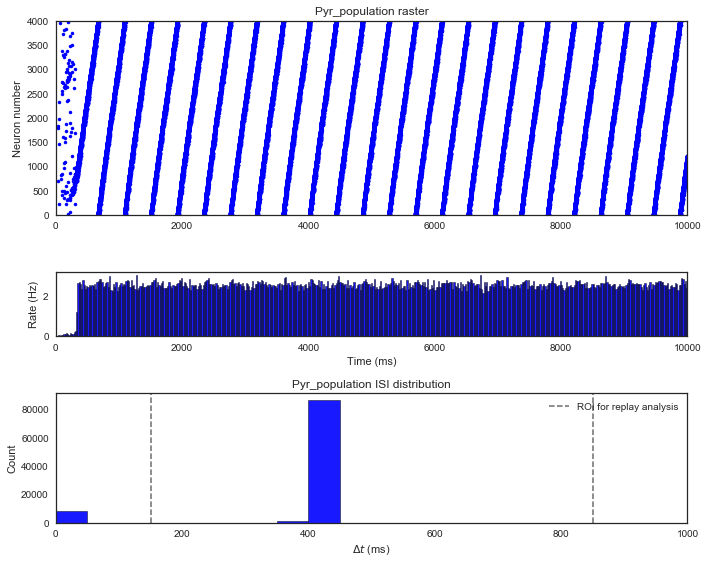

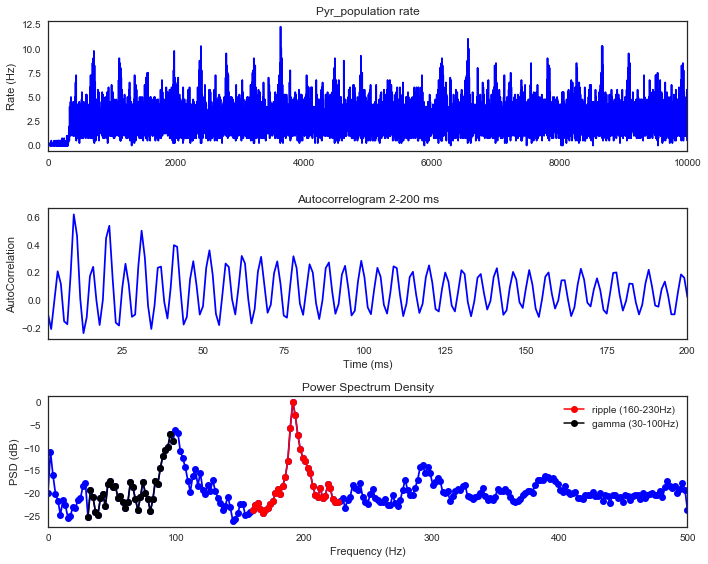

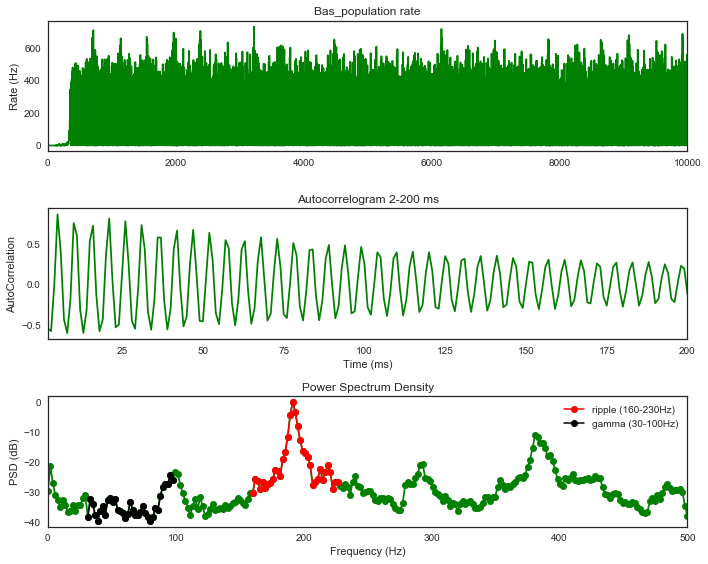

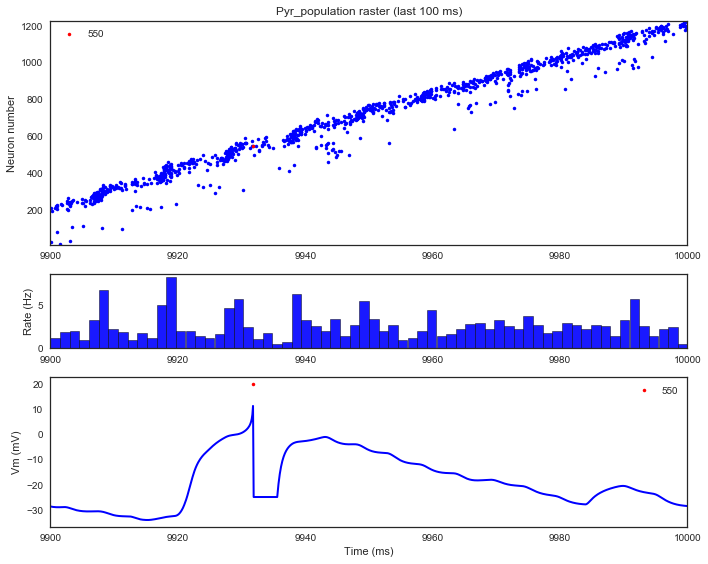

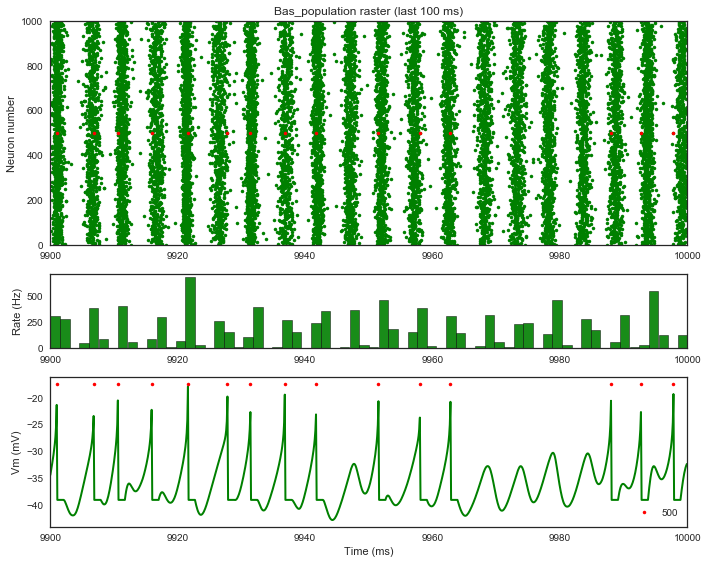

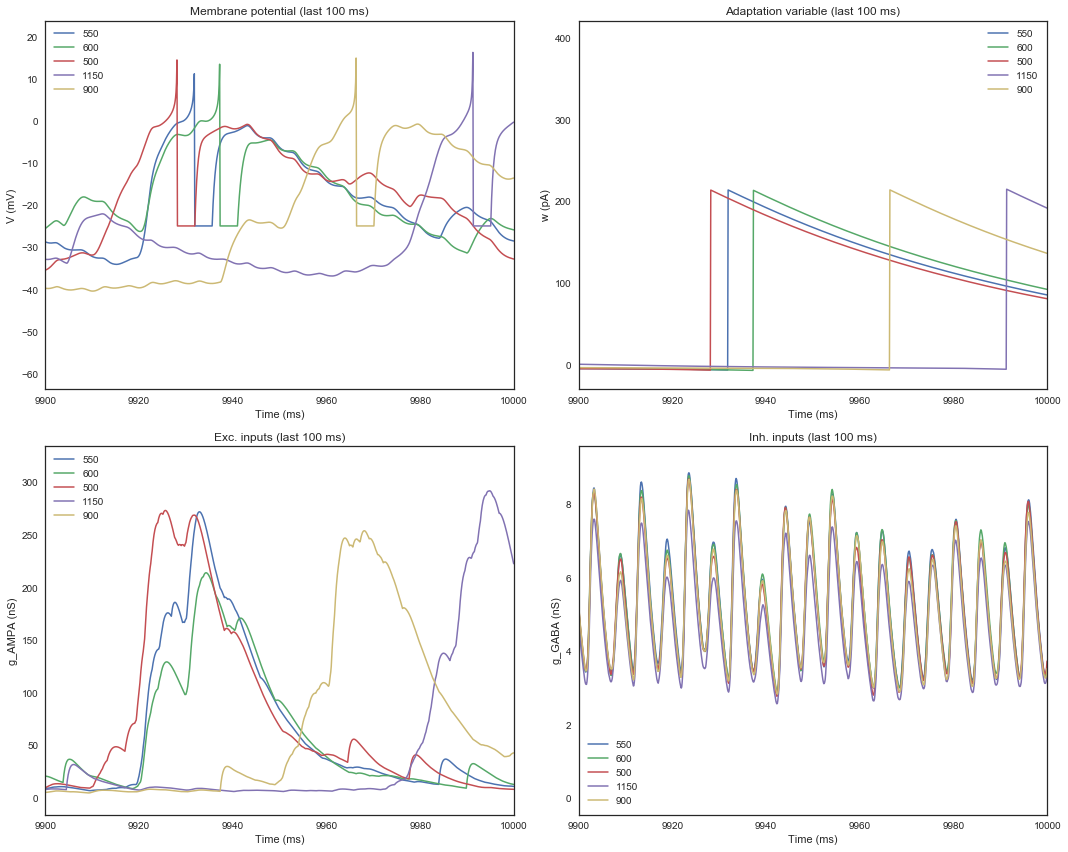

In [13]:
# Plots
if sme.num_spikes > 0 and smi.num_spikes > 0:  # check if there is any activity
    
    plot_raster_ISI(spikeTimesE, spikingNeuronsE, poprE, [ISIhist, bin_edges], 'blue', multiplier_=1)
    plot_PSD(poprE, rEAC, fE, PxxE, "Pyr_population", 'b-', multiplier_=1)
    plot_PSD(poprI, rIAC, fI, PxxI, "Bas_population", 'g-', multiplier_=1)

    subset = plot_zoomed(spikeTimesE, spikingNeuronsE, poprE, "Pyr_population", "blue", multiplier_=1,
                         sm=mSME, selection=selection)
    plot_zoomed(spikeTimesI, spikingNeuronsI, poprI, "Bas_population", "green", multiplier_=1, Pyr_pop=False, sm=sMI)
    plot_detailed(msMe, subset, multiplier_=1, new_network=True)